In [1]:
#Importing Libraries
import sqlite3
import pandas as pd

In [2]:
#Connecting to SQLite Database
db_path = "MIG_Cement_Records.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

In [3]:
# Example Query: List all tables in the database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables:", tables)

Tables: [('Sites',), ('CementTypes',), ('Operations',)]


In [4]:
tables

[('Sites',), ('CementTypes',), ('Operations',)]

In [5]:
# For each table, print its schema and a few sample rows
for table_name, in tables:
    print(f"\n=== {table_name} ===")
    
    schema = cursor.execute(f"PRAGMA table_info({table_name});").fetchall()
    print("Schema:", schema)
    
    rows = cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;").fetchall()
    print("Sample rows:", rows)


=== Sites ===
Schema: [(0, 'site_id', 'TEXT', 0, None, 1), (1, 'region', 'TEXT', 0, None, 0), (2, 'silo_capacity', 'INTEGER', 0, None, 0), (3, 'behavior', 'TEXT', 0, None, 0)]
Sample rows: [('SITE_001', 'North', 448, 'aggressive'), ('SITE_002', 'South', 288, 'conservative'), ('SITE_003', 'East', 314, 'aggressive'), ('SITE_004', 'South', 472, 'conservative'), ('SITE_005', 'South', 230, 'aggressive')]

=== CementTypes ===
Schema: [(0, 'cement_type', 'TEXT', 0, None, 1)]
Sample rows: [('CEM_I',), ('CEM_II',), ('CEM_III',)]

=== Operations ===
Schema: [(0, 'date', 'TEXT', 0, None, 0), (1, 'site_id', 'TEXT', 0, None, 0), (2, 'cement_type', 'TEXT', 0, None, 0), (3, 'planned_pour_tonnes', 'REAL', 0, None, 0), (4, 'consumed_tonnes', 'REAL', 0, None, 0), (5, 'opening_inventory_tonnes', 'REAL', 0, None, 0), (6, 'deliveries_tonnes', 'REAL', 0, None, 0), (7, 'closing_inventory_tonnes', 'REAL', 0, None, 0), (8, 'rain_mm', 'REAL', 0, None, 0), (9, 'avg_temp_c', 'REAL', 0, None, 0), (10, 'silo_capac

In [6]:
# Complex Query: Join Operations with Sites and CementTypes
query = """
SELECT 
    o.date,
    o.site_id,
    s.region,
    s.behavior,
    o.cement_type,
    o.planned_pour_tonnes,
    o.consumed_tonnes,
    o.opening_inventory_tonnes,
    o.deliveries_tonnes,
    o.closing_inventory_tonnes,
    o.rain_mm,
    o.avg_temp_c,
    o.silo_capacity
FROM Operations o
JOIN Sites s ON o.site_id = s.site_id
JOIN CementTypes c ON o.cement_type = c.cement_type;
"""

In [7]:
# Ingesting Data into Pandas DataFrame
df = pd.read_sql_query(query, conn)
conn.close()
df['date'] = pd.to_datetime(df['date'])

In [8]:
# Initial Data Exploration
print("Shape:", df.shape)
display("Columns:", df.columns.tolist())
display("Missing values:\n", df.isnull().sum())

Shape: (32880, 13)


'Columns:'

['date',
 'site_id',
 'region',
 'behavior',
 'cement_type',
 'planned_pour_tonnes',
 'consumed_tonnes',
 'opening_inventory_tonnes',
 'deliveries_tonnes',
 'closing_inventory_tonnes',
 'rain_mm',
 'avg_temp_c',
 'silo_capacity']

'Missing values:\n'

date                        0
site_id                     0
region                      0
behavior                    0
cement_type                 0
planned_pour_tonnes         0
consumed_tonnes             0
opening_inventory_tonnes    0
deliveries_tonnes           0
closing_inventory_tonnes    0
rain_mm                     0
avg_temp_c                  0
silo_capacity               0
dtype: int64

In [9]:
# Checking for negative values in numeric columns
numeric_cols = [
    "planned_pour_tonnes", "consumed_tonnes", "opening_inventory_tonnes",
    "deliveries_tonnes", "closing_inventory_tonnes", "rain_mm", "avg_temp_c"
]
print("Negative values check:")
print((df[numeric_cols] < 0).sum())

Negative values check:
planned_pour_tonnes            0
consumed_tonnes                0
opening_inventory_tonnes       0
deliveries_tonnes              0
closing_inventory_tonnes       0
rain_mm                        0
avg_temp_c                  4551
dtype: int64


Cement operations data (planned pour, consumed tonnes, inventories, rainfall, etc.) should never be negative. Negative values here would usually mean:

Data entry error (e.g., typo or mis-logged sensor values).

ETL pipeline issues (if values flipped during ingestion).

Operational anomaly (rare case, but sometimes systems subtract incorrectly when reconciling stock).

Importance:

It ensures your data aligns with physical reality (you can’t have negative cement or negative rainfall).

Cleaning these early prevents skewed analysis and forecasts later.

In [10]:
# Inventory Flow Consistency Check
# This formula is essentially a sanity check for whether the inventory flow balances: Opening stock + Deliveries – Consumed = Closing stock
df["inventory_check"] = (
    df["opening_inventory_tonnes"] + df["deliveries_tonnes"] - df["consumed_tonnes"]
).round(2) == df["closing_inventory_tonnes"].round(2)
print("Inventory flow valid rows:", df["inventory_check"].mean())

Inventory flow valid rows: 0.999787104622871


Importance:

- It validates data consistency — making sure operational records reconcile properly.

If this check fails often, it highlights pain points like:
- Poor stock tracking at sites.
- Unrecorded deliveries/consumption.
- Manual reporting errors.

Business angle:
- High mismatch rate = weak operational visibility, which directly causes:
- Wastage/leakage in cement supply chain.
- Poor forecasting accuracy (demand/inventory misaligned).
- Higher costs due to emergency deliveries or stockouts.

### Findings from inventory check

- Operational records are very consistent: Almost all rows reconcile (opening + deliveries – consumption ≈ closing).

In business terms: this shows the construction sites are tracking inventory well, so any insights we derive (about consumption, deliveries, capacity, etc.) will be reliable.

In [11]:
# KPI Derivations - to see business problem through data
# These KPIs help identify operational issues at construction sites:
# - Stockouts: When planned pour exceeds available stock (opening + deliveries).
# - Overcapacity: When closing inventory exceeds silo capacity.
# - Idle periods: When there's no planned pour and no deliveries.
# - Waste risk: When inventory is very high but planned pour is low (risk of cement going bad).
# - Pour disruptions: When there's a planned pour but no consumption (indicating a problem).
df['stockout'] = df['planned_pour_tonnes'] > (df['opening_inventory_tonnes'] + df['deliveries_tonnes'])
df['overcapacity'] = df['closing_inventory_tonnes'] > df['silo_capacity']
df['idle'] = (df['planned_pour_tonnes'] == 0) & (df['deliveries_tonnes'] == 0)
df['waste_risk'] = (df['closing_inventory_tonnes'] > 0.85 * df['silo_capacity']) & (df['planned_pour_tonnes'] < 5)
df['pour_disrupted'] = (df['planned_pour_tonnes'] > 0) & (df['consumed_tonnes'] == 0)


In [12]:
# Aggregated KPI Summary by Site
# This summarizes key metrics per construction site to identify patterns and issues.
kpi_summary = df.groupby("site_id").agg(
    total_days=("date", "count"),
    total_consumed_tonnes=("consumed_tonnes", "sum"),
    avg_daily_consumed=("consumed_tonnes", "mean"),
    stockout_pct=("stockout", lambda x: round(x.mean() * 100, 2)),
    overcapacity_pct=("overcapacity", lambda x: round(x.mean() * 100, 2)),
    idle_pct=("idle", lambda x: round(x.mean() * 100, 2)),
    waste_risk_pct=("waste_risk", lambda x: round(x.mean() * 100, 2)),
    pour_disrupted_pct=("pour_disrupted", lambda x: round(x.mean() * 100, 2)),
    silo_capacity=("silo_capacity", "first"),
    region=("region", "first")
).reset_index()


In [13]:
display(kpi_summary)

,site_id,total_days,total_consumed_tonnes,avg_daily_consumed,stockout_pct,overcapacity_pct,idle_pct,waste_risk_pct,pour_disrupted_pct,silo_capacity,region
0,SITE_001,1096,33056.40,30.160949,55.75,0.00,0.00,0.00,4.84,448,North
1,SITE_002,1096,12900.44,11.770474,0.00,98.81,0.00,3.56,0.00,288,South
2,SITE_003,1096,32520.09,29.671615,54.38,0.00,0.00,0.00,5.75,314,East
3,SITE_004,1096,12618.50,11.513230,0.00,98.08,0.00,4.93,0.00,472,South
4,SITE_005,1096,32935.68,30.050803,56.93,0.00,0.00,0.00,4.38,230,South
5,SITE_006,1096,28601.16,26.095949,16.15,0.00,2.55,0.09,3.47,443,East
6,SITE_007,1096,32607.65,29.751505,57.03,0.00,0.00,0.00,5.20,485,East
7,SITE_008,1096,32689.50,29.826186,60.49,0.00,0.00,0.00,4.47,260,West
8,SITE_009,1096,12735.31,11.619808,0.00,98.81,0.00,4.29,0.00,352,East
9,SITE_010,1096,33579.76,30.638467,57.03,0.00,0.00,0.00,4.56,158,West


In [14]:
# After your initial KPI analysis, save the results
kpi_summary.to_csv("historical_kpi_summary.csv", index=False)

## KPI Summary – Site Performance Insights

### 1. Site Groupings
- **High Consumption Sites (~30 t/day, ~33k t total)**
  - Examples: SITE_001, SITE_003, SITE_005, SITE_007, SITE_010, SITE_017
  - Pattern: High **stockouts (54–61%)**, no overcapacity/waste.
  - Risk: **Under-supplied**, silos too small for demand.

- **Low Consumption Sites (~11–12 t/day, ~12–13k t total)**
  - Examples: SITE_002, SITE_004, SITE_009, SITE_012, SITE_015, SITE_019
  - Pattern: Extreme **overcapacity (98–99%)**, some waste risk (3–5%).
  - Risk: **Over-supplied**, excess inventory and spoilage risk.

- **Mid-Tier / Mixed Sites (~26–27 t/day, ~29–30k t total)**
  - Examples: SITE_013, SITE_014, SITE_016, SITE_024, SITE_026, SITE_028
  - Pattern: Both **stockouts (5–12%)** and **overcapacity (6–50%)**, some idle & waste.
  - Risk: **Unstable supply-demand balance**, harder to forecast.


### 2. Regional Trends
- **South:** Many overcapacity sites, some mid-tier mismatches.  
- **East:** Mix of stockout-heavy high-demand sites and mid-tier volatile ones.  
- **North:** Polarized – some stockout-heavy, some overcapacity.  
- **West:** Stockout-heavy high-demand sites plus a few volatile sites.  


### 3. Key Risks
- **Stockout Hotspots:** High-demand (~30 t/day) sites → continuity risk.  
- **Overcapacity Hotspots:** Low-demand (~11 t/day) sites → spoilage/cost risk.  
- **Volatile Sites:** Mid-tier (~26–27 t/day) sites → planning challenge.  


✅ In short:  
- Half the sites are **starved of supply**.  
- Half are **over-supplied**.  
- A few are **swinging between both extremes**.  
- Silo sizing and supply allocation don’t match real demand.


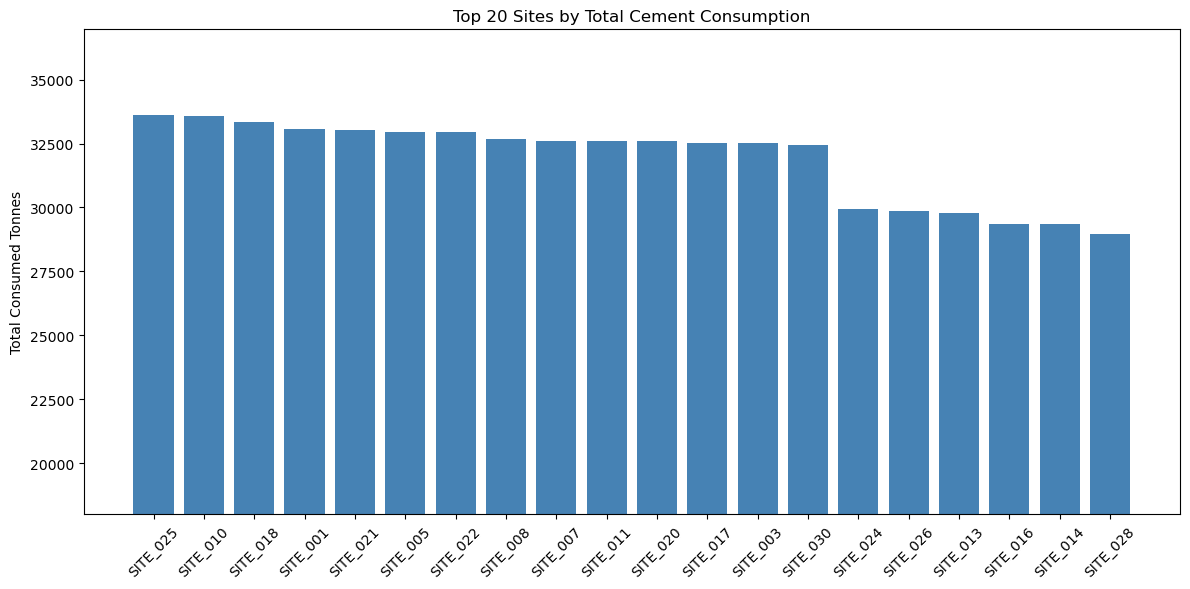

In [15]:
# KPI Summary – Site Performance Insights
import matplotlib.pyplot as plt
import seaborn as sns

top_sites = kpi_summary.sort_values("total_consumed_tonnes", ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.bar(top_sites["site_id"], top_sites["total_consumed_tonnes"], color="steelblue")
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Total Cement Consumption")
plt.ylim(18000, top_sites["total_consumed_tonnes"].max() * 1.1)
plt.ylabel("Total Consumed Tonnes")
plt.tight_layout()
plt.show()

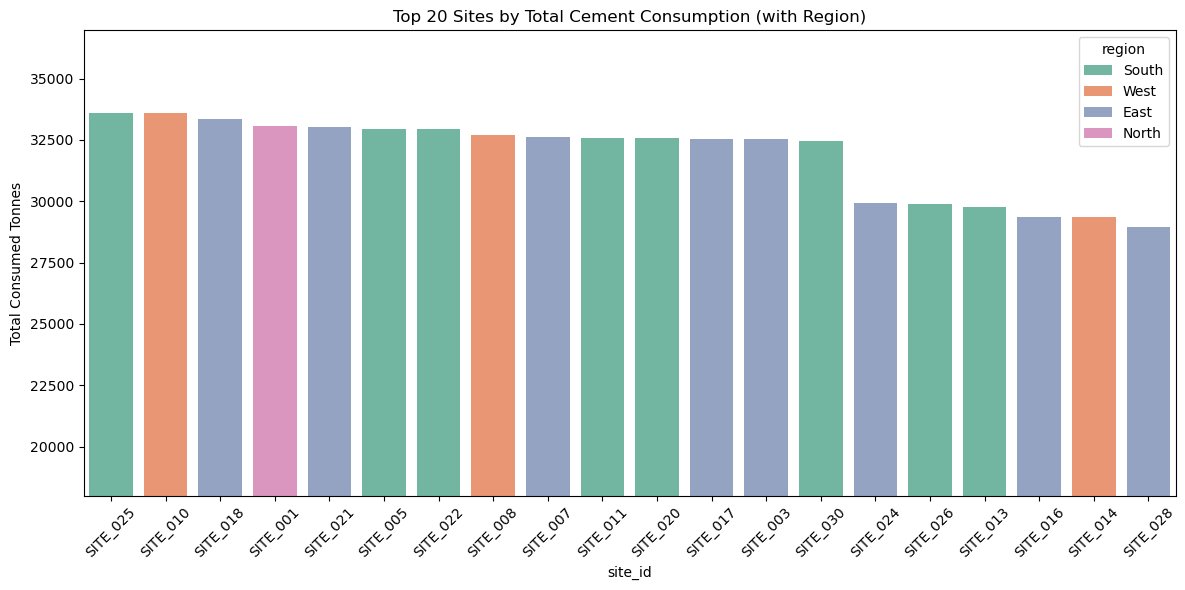

In [16]:
# Enhanced Visualization with Region Coloring
plt.figure(figsize=(12,6))
sns.barplot(
    x="site_id", 
    y="total_consumed_tonnes", 
    data=top_sites, 
    hue="region", 
    dodge=False, 
    palette="Set2"
)
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Total Cement Consumption (with Region)")
plt.ylabel("Total Consumed Tonnes")
plt.ylim(18000, top_sites["total_consumed_tonnes"].max() * 1.1)
plt.tight_layout()
plt.show()


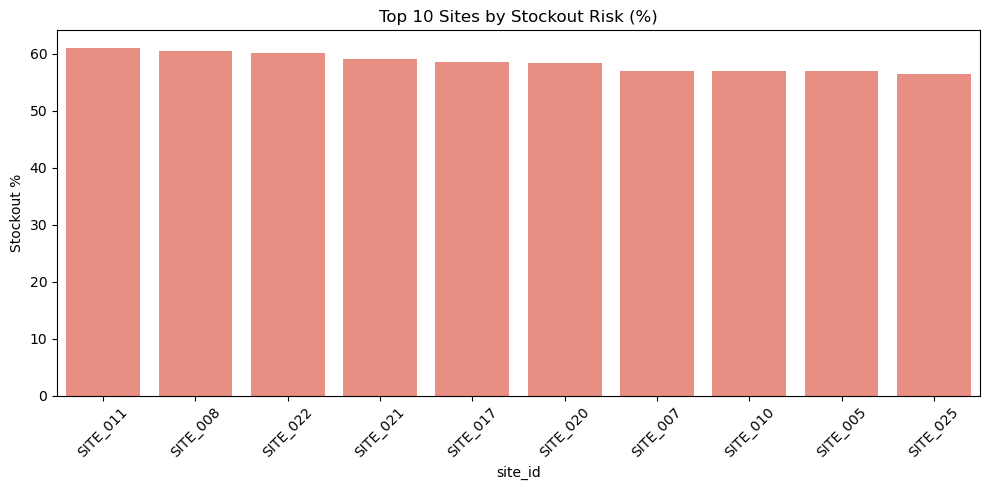

In [17]:
# Highlighting High-Risk Sites
# Focus on sites with highest stockout percentages to identify critical supply issues.
risk_sites = kpi_summary.sort_values("stockout_pct", ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x="site_id", y="stockout_pct", data=risk_sites, color="salmon")
plt.xticks(rotation=45)
plt.title("Top 10 Sites by Stockout Risk (%)")
plt.ylabel("Stockout %")
plt.tight_layout()
plt.show()


C:\Users\ALAGBE-OOA\AppData\Local\Temp\ipykernel_22452\3387625416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="site_id", y="stockout_pct", data=stockout_sites, palette="Reds_r")


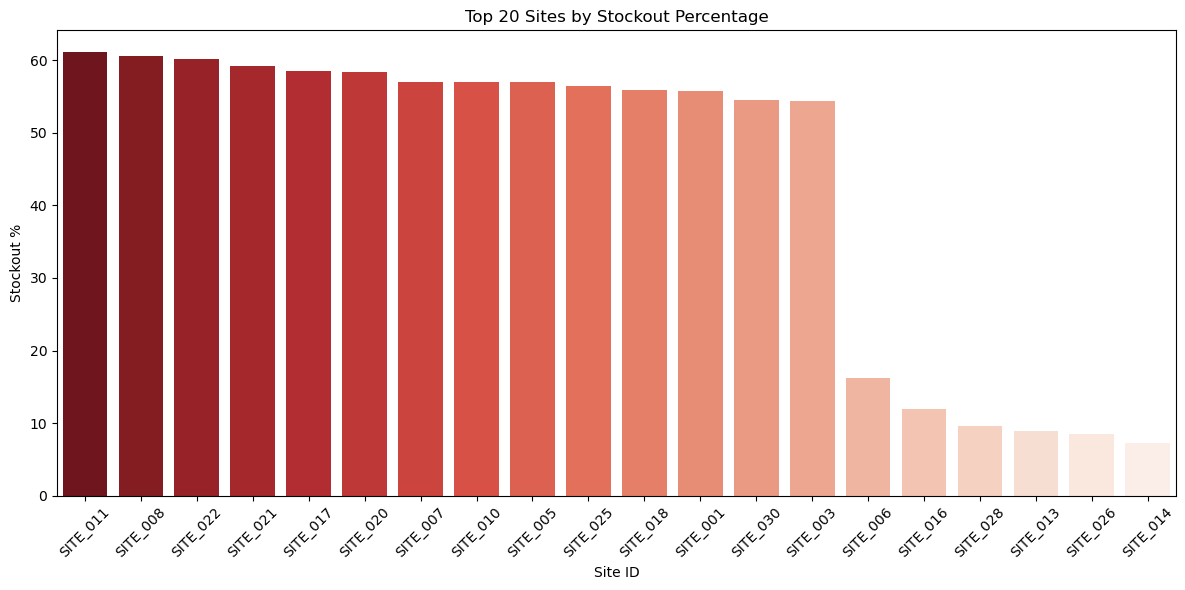

In [18]:
# Top 20 Sites by Stockout Percentage
plt.figure(figsize=(12, 6))
stockout_sites = kpi_summary.sort_values("stockout_pct", ascending=False).head(20)
sns.barplot(x="site_id", y="stockout_pct", data=stockout_sites, palette="Reds_r")
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Stockout Percentage")
plt.ylabel("Stockout %")
plt.xlabel("Site ID")
plt.tight_layout()
plt.show()


C:\Users\ALAGBE-OOA\AppData\Local\Temp\ipykernel_22452\2030914595.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="site_id", y="overcapacity_pct", data=overcapacity_sites, palette="Blues_r")


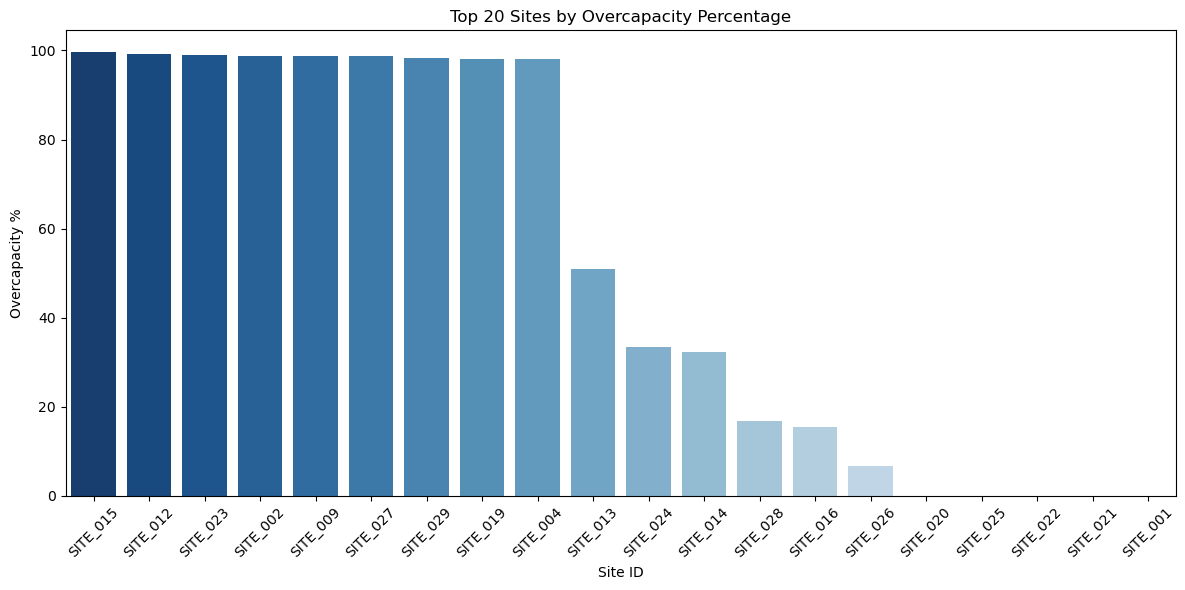

In [19]:
# Top 20 Sites by Overcapacity Percentage
plt.figure(figsize=(12, 6))
overcapacity_sites = kpi_summary.sort_values("overcapacity_pct", ascending=False).head(20)
sns.barplot(x="site_id", y="overcapacity_pct", data=overcapacity_sites, palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Overcapacity Percentage")
plt.ylabel("Overcapacity %")
plt.xlabel("Site ID")
plt.tight_layout()
plt.show()


C:\Users\ALAGBE-OOA\AppData\Local\Temp\ipykernel_22452\537691121.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="site_id", y="idle_pct", data=idle_sites, palette="Greens_r")


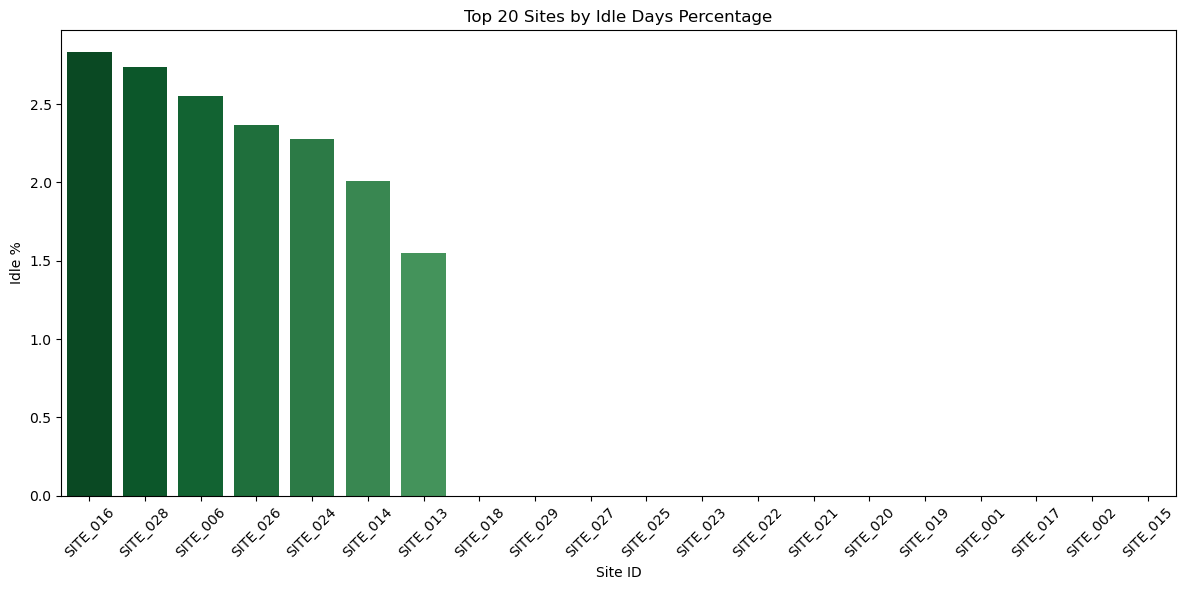

In [20]:
# Top 20 Sites by Idle Days Percentage
plt.figure(figsize=(12, 6))
idle_sites = kpi_summary.sort_values("idle_pct", ascending=False).head(20)
sns.barplot(x="site_id", y="idle_pct", data=idle_sites, palette="Greens_r")
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Idle Days Percentage")
plt.ylabel("Idle %")
plt.xlabel("Site ID")
plt.tight_layout()
plt.show()


C:\Users\ALAGBE-OOA\AppData\Local\Temp\ipykernel_22452\1014203020.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="site_id", y="waste_risk_pct", data=waste_sites, palette="Oranges_r")


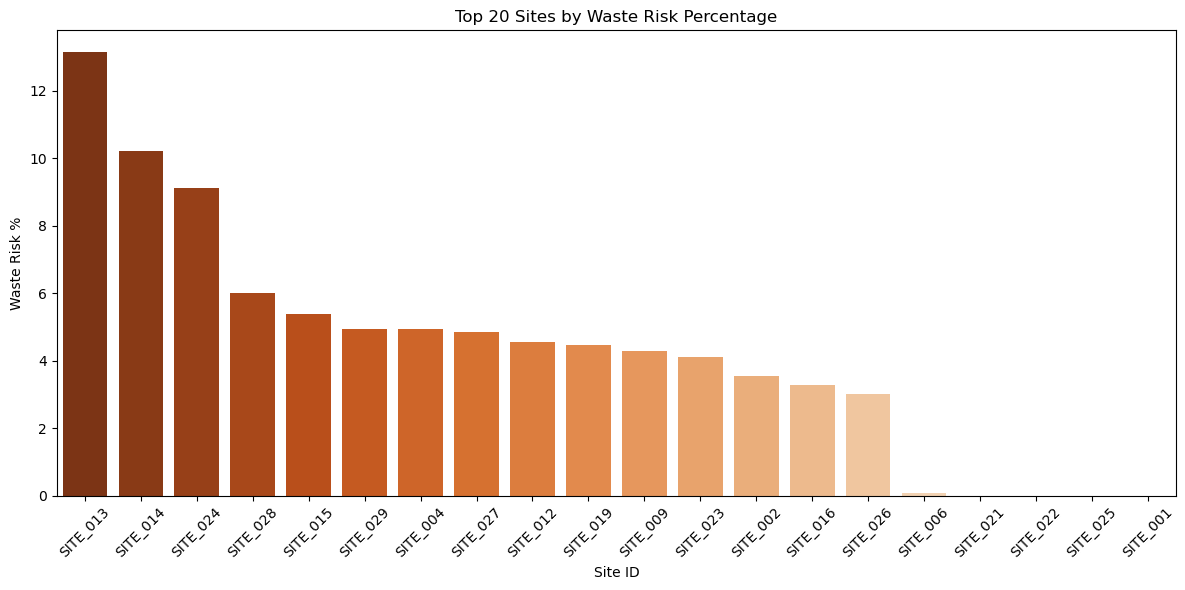

In [21]:
# Top 20 Sites by Waste Risk Percentage
plt.figure(figsize=(12, 6))
waste_sites = kpi_summary.sort_values("waste_risk_pct", ascending=False).head(20)
sns.barplot(x="site_id", y="waste_risk_pct", data=waste_sites, palette="Oranges_r")
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Waste Risk Percentage")
plt.ylabel("Waste Risk %")
plt.xlabel("Site ID")
plt.tight_layout()
plt.show()


C:\Users\ALAGBE-OOA\AppData\Local\Temp\ipykernel_22452\2540348827.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="site_id", y="pour_disrupted_pct", data=disrupted_sites, palette="Purples_r")


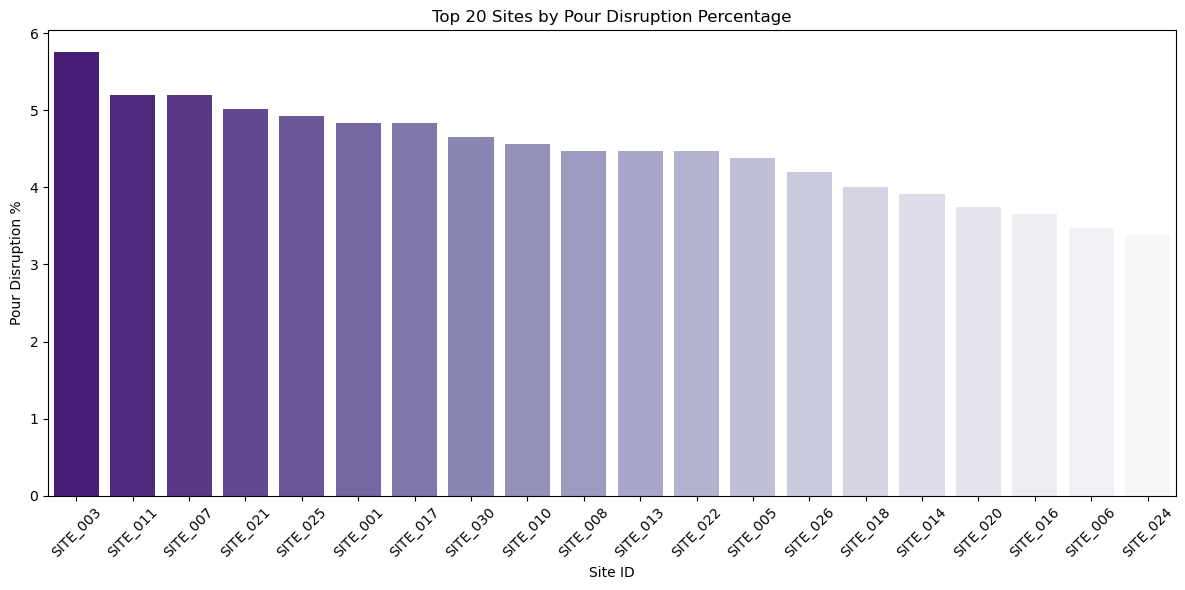

In [22]:
# Top 20 Sites by Pour Disruption Percentage
plt.figure(figsize=(12, 6))
disrupted_sites = kpi_summary.sort_values("pour_disrupted_pct", ascending=False).head(20)
sns.barplot(x="site_id", y="pour_disrupted_pct", data=disrupted_sites, palette="Purples_r")
plt.xticks(rotation=45)
plt.title("Top 20 Sites by Pour Disruption Percentage")
plt.ylabel("Pour Disruption %")
plt.xlabel("Site ID")
plt.tight_layout()
plt.show()


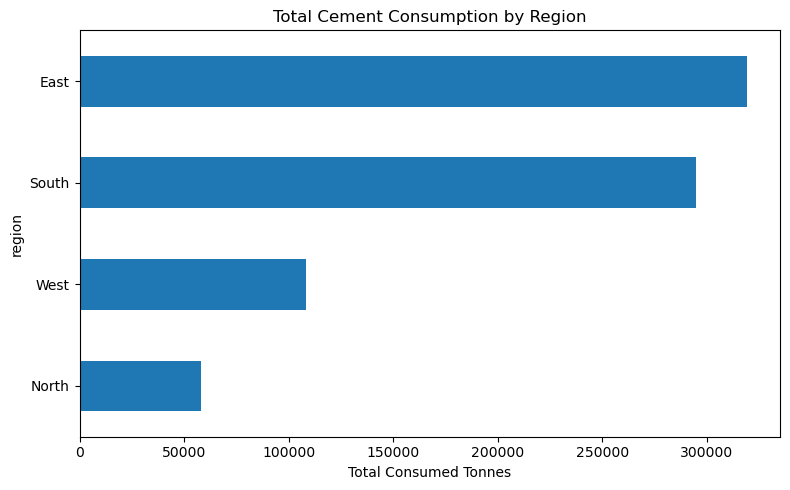

In [23]:
# Total Cement Consumption by Region
region_consumption = df.groupby("region")["consumed_tonnes"].sum().sort_values()
region_consumption.plot(kind="barh", figsize=(8, 5), title="Total Cement Consumption by Region")
plt.xlabel("Total Consumed Tonnes")
plt.tight_layout()

<Axes: title={'center': 'Avg Rainfall on Disrupted Pour Days'}, xlabel='site_id'>

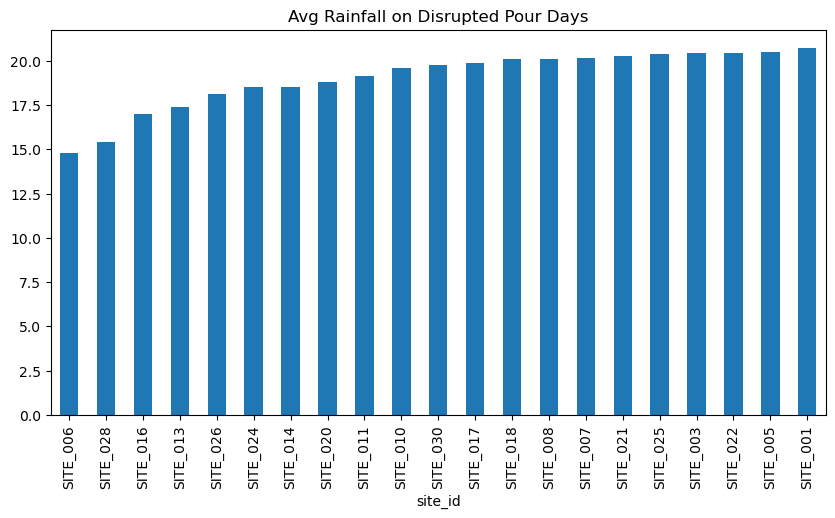

In [24]:
# Average Rainfall on Disrupted Pour Days by Site
# This shows if weather is a significant factor in pour disruptions at certain sites.
weather_disruption = df[df["pour_disrupted"]].groupby("site_id")["rain_mm"].mean().sort_values()
weather_disruption.plot(kind="bar", figsize=(10, 5), title="Avg Rainfall on Disrupted Pour Days")

<Axes: title={'center': 'Average Silo Utilization by Site'}, xlabel='site_id'>

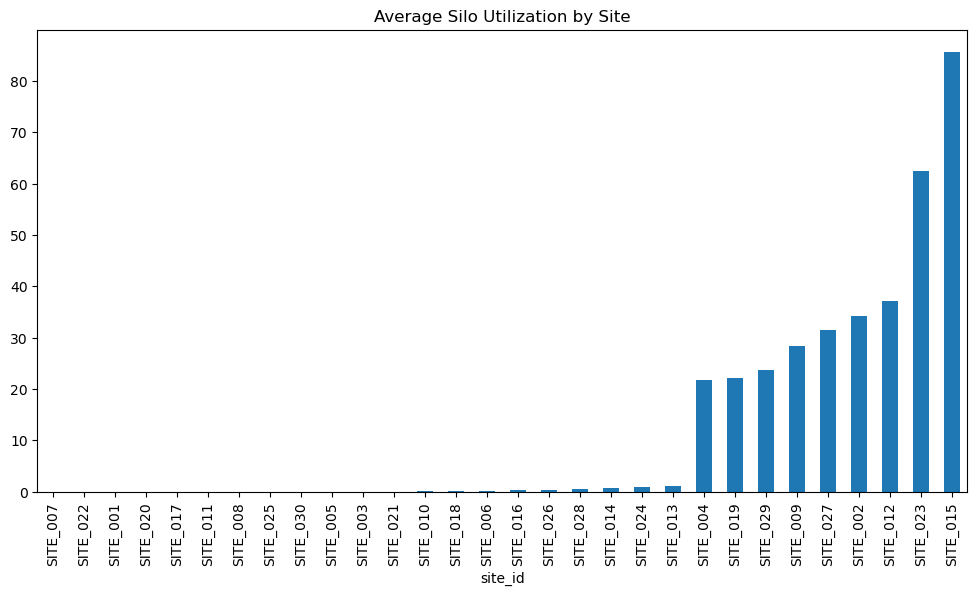

In [25]:
# Silo Utilization Analysis
# Understanding how effectively silo capacity is being used across sites.
df["utilization_pct"] = df["closing_inventory_tonnes"] / df["silo_capacity"]
utilization_summary = df.groupby("site_id")["utilization_pct"].mean().sort_values()
utilization_summary.plot(kind="bar", figsize=(12, 6), title="Average Silo Utilization by Site")


<Axes: title={'center': 'KPI Comparison by Site Behavior'}, xlabel='behavior'>

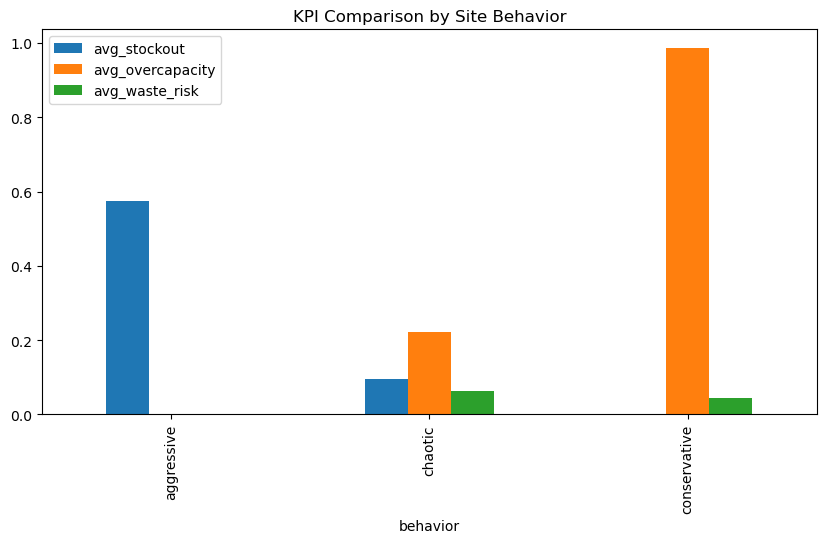

In [26]:
# KPI Comparison by Site Behavior
# Comparing key performance indicators across different site behaviors to identify trends.
behavior_kpi = df.groupby("behavior").agg(
    avg_stockout=("stockout", "mean"),
    avg_overcapacity=("overcapacity", "mean"),
    avg_waste_risk=("waste_risk", "mean")
)
behavior_kpi.plot(kind="bar", figsize=(10, 5), title="KPI Comparison by Site Behavior")

<Axes: title={'center': 'Cement Type Demand Share'}, ylabel='consumed_tonnes'>

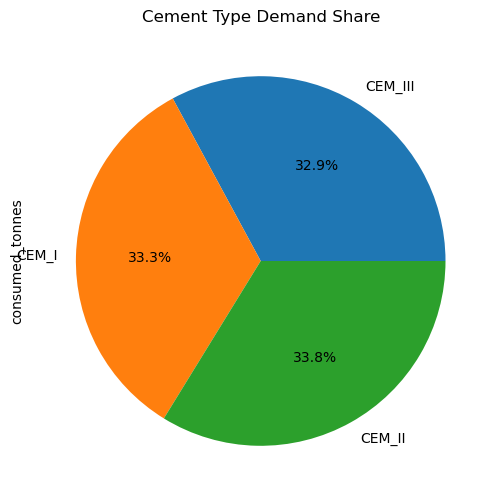

In [27]:
# Cement Type Demand Share
# Understanding which cement types are most consumed to optimize inventory and supply chain.
cement_demand = df.groupby("cement_type")["consumed_tonnes"].sum().sort_values()
cement_demand.plot(kind="pie", autopct="%1.1f%%", figsize=(6, 6), title="Cement Type Demand Share")


<Axes: title={'center': 'Monthly Cement Demand Seasonality'}, xlabel='month'>

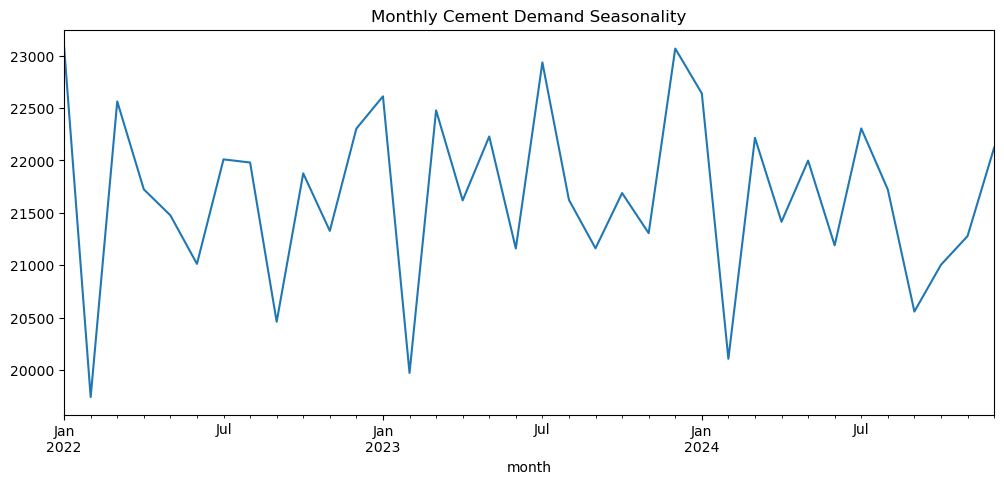

In [28]:
# Monthly Cement Demand Seasonality
# Identifying seasonal trends in cement consumption to better plan logistics and inventory.
df["month"] = df["date"].dt.to_period("M")
monthly_demand = df.groupby("month")["consumed_tonnes"].sum()
monthly_demand.plot(figsize=(12, 5), title="Monthly Cement Demand Seasonality")


In [29]:
# Total cement consumption per site
site_usage = df.groupby("site_id")["consumed_tonnes"].sum().sort_values(ascending=False)

# Total consumption across all sites
total_usage = site_usage.sum()

# Top 5 sites and their share of total usage
top5 = site_usage.head(5)
top5_share = round(top5.sum() / total_usage * 100, 2)

print("Top 5 Sites by Cement Usage:")
print(top5)

print(f"\nThese top 5 sites account for {top5_share}% of total cement consumption.")


Top 5 Sites by Cement Usage:
site_id
SITE_025    33604.06
SITE_010    33579.76
SITE_018    33348.09
SITE_001    33056.40
SITE_021    33009.68
Name: consumed_tonnes, dtype: float64

These top 5 sites account for 21.36% of total cement consumption.


## Modelling

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [31]:
import warnings
warnings.filterwarnings("ignore")


In [32]:
# Focusing on a single site for detailed time series analysis
site_id = "SITE_001"
site_df = df[df['site_id'] == site_id].copy()
site_df.set_index('date', inplace=True)
site_df = site_df.sort_index()

In [33]:
site_df.head()

,site_id,region,behavior,cement_type,planned_pour_tonnes,consumed_tonnes,opening_inventory_tonnes,deliveries_tonnes,closing_inventory_tonnes,rain_mm,avg_temp_c,silo_capacity,inventory_check,stockout,overcapacity,idle,waste_risk,pour_disrupted,utilization_pct,month
date,,,,,,,,,,,,,,,,,,,,
2022-01-01,SITE_001,North,aggressive,CEM_II,43.18,34.54,52.56,45.83,63.85,3.40,-3.10,448,True,False,False,False,False,False,0.142522,2022-01
2022-01-02,SITE_001,North,aggressive,CEM_I,45.26,45.26,63.85,19.97,38.56,3.23,14.28,448,True,False,False,False,False,False,0.086071,2022-01
2022-01-03,SITE_001,North,aggressive,CEM_III,38.69,38.69,38.56,47.19,47.06,2.64,6.40,448,True,False,False,False,False,False,0.105045,2022-01
2022-01-04,SITE_001,North,aggressive,CEM_I,33.16,33.16,47.06,18.74,32.64,8.25,14.23,448,True,False,False,False,False,False,0.072857,2022-01
2022-01-05,SITE_001,North,aggressive,CEM_III,56.88,47.04,32.64,14.40,0.00,2.69,8.97,448,True,True,False,False,False,False,0.000000,2022-01


In [34]:
y = site_df['consumed_tonnes']

exog = site_df[['planned_pour_tonnes', 'rain_mm', 'avg_temp_c']]

In [35]:
# Train-test split (80-20)
split_index = int(len(site_df) * 0.8)
X_train, X_test = exog.iloc[:split_index], exog.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [36]:
model = ARIMA(
    y_train,
    exog=X_train,
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_arima = model.fit()
print("="*40)
print("         ARIMA Model Results        ")
print("="*40)
print(results_arima.summary())


         ARIMA Model Results        
                               SARIMAX Results                                
Dep. Variable:        consumed_tonnes   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3407.042
Date:                Sat, 28 Feb 2026   AIC                           6826.084
Time:                        17:52:39   BIC                           6854.716
Sample:                    01-01-2022   HQIC                          6837.038
                         - 05-25-2024                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
planned_pour_tonnes     0.5520      0.038     14.606      0.000       0.478       0.626
rain_mm                -0.8576      0.065    -13.100      0.000    

In [37]:
# Forecasting with SARIMAX
arima_forecast = results_arima.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

In [38]:
# Visualizing SARIMAX Forecast vs Actual
import plotly.graph_objects as go

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=y_test.index, 
    y=y_test, 
    mode="lines", 
    name="Actual", 
    line=dict(color="black")
))

# Forecast values
fig.add_trace(go.Scatter(
    x=y_test.index, 
    y=arima_forecast, 
    mode="lines", 
    name="Forecast", 
    line=dict(color="red")
))

# Layout
fig.update_layout(
    title=f"ARIMA Forecast vs Actual - {site_id}",
    xaxis_title="Date",
    yaxis_title="Cement Consumed (Tonnes)",
    legend=dict(x=0, y=1),
    template="plotly_white",
    width=1000,
    height=450
)

fig.show()


In [39]:
# Decision tree with Exogenous Variables

from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(
    max_depth=5, random_state=42
)
dt_model.fit(X_train, y_train)

dt_forecast = dt_model.predict(X_test)

In [40]:
# Visualizing Decision Tree Forecast vs Actual~
import plotly.graph_objects as go

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=y_test.index, 
    y=y_test, 
    mode="lines", 
    name="Actual", 
    line=dict(color="black")
))

# Forecast values
fig.add_trace(go.Scatter(
    x=y_test.index, 
    y=dt_forecast, 
    mode="lines", 
    name="Forecast", 
    line=dict(color="green")
))

# Layout
fig.update_layout(
    title=f"Decision Tree Forecast vs Actual - {site_id}",
    xaxis_title="Date",
    yaxis_title="Cement Consumed (Tonnes)",
    legend=dict(x=0, y=1),
    template="plotly_white",
    width=1000,
    height=450
)

fig.show()

In [41]:
# Evaluation Metrics
import numpy as np
from sklearn.metrics import mean_squared_error

def print_metrics(y_true, y_pred, label):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} - MAPE: {mape:.2f}%, RMSE: {rmse:.2f} tonnes")

In [42]:
# Comparing ARIMA and Decision Tree
print_metrics(y_test, arima_forecast, "ARIMA")
print_metrics(y_test, dt_forecast, "Decision Tree")

ARIMA - MAPE: 36.15%, RMSE: 11.73 tonnes
Decision Tree - MAPE: 34.00%, RMSE: 10.06 tonnes


Why Decision Tree is working better than ARIMA

* ARIMA is best for linear time series and autoregressive trends.

* Decision Trees are superior when the pattern between input features and target is complex,    nonlinear, or when many contextual signals (weather, events, site type) influence the forecast.

In [43]:
# Enhanced Feature Engineering for Decision Tree
from sklearn.preprocessing import StandardScaler

# Filter for one site
site_df = df[df['site_id'] == 'SITE_001'].copy().sort_values('date')
site_df.set_index('date', inplace=True)

# Feature Engineering
# Lag features
site_df['lag_1'] = site_df['consumed_tonnes'].shift(1)
site_df['lag_3'] = site_df['consumed_tonnes'].shift(3)
site_df['lag_7'] = site_df['consumed_tonnes'].shift(7)

# Rolling statistics
site_df['rolling_mean_3'] = site_df['consumed_tonnes'].rolling(3).mean()
site_df['rolling_std_7'] = site_df['consumed_tonnes'].rolling(7).std()

# Date-based features
site_df['day_of_week'] = site_df.index.dayofweek
site_df['week_of_year'] = site_df.index.isocalendar().week
site_df['month'] = site_df.index.month

# Interaction features
site_df['rain_x_pour'] = site_df['rain_mm'] * site_df['planned_pour_tonnes']
site_df['temp_x_pour'] = site_df['avg_temp_c'] * site_df['planned_pour_tonnes']

# Inventory-related features
site_df['inventory_gap'] = site_df['opening_inventory_tonnes'] + site_df['deliveries_tonnes'] - site_df['planned_pour_tonnes']
site_df['inventory_ratio'] = site_df['closing_inventory_tonnes'] / site_df['silo_capacity']

# Encoding categorical variables
site_df['behavior_encoded'] = site_df['behavior'].astype('category').cat.codes
site_df['cement_type_encoded'] = site_df['cement_type'].astype('category').cat.codes

# Drop NaNs from lag/rolling features
site_df.dropna(inplace=True)

# Define features and target
features = [
    'planned_pour_tonnes', 'rain_mm', 'avg_temp_c',
    'lag_1', 'lag_3', 'lag_7',
    'rolling_mean_3', 'rolling_std_7',
    'rain_x_pour', 'temp_x_pour',
    'inventory_gap', 'inventory_ratio',
    'behavior_encoded', 'cement_type_encoded'
]

# Prepare data
X = site_df[features]
y = site_df['consumed_tonnes']

# Train-test split (time series)
split_index = int(len(site_df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train Decision Tree Forest
dt_model = DecisionTreeRegressor(
    max_depth=5, random_state=42
)
dt_model.fit(X_train, y_train)

# Predict
dt_forecast = dt_model.predict(X_test)

# Evaluate
def print_metrics(y_true, y_pred, label):
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} - MAPE: {mape:.2f}%, RMSE: {rmse:.2f} tonnes")

# Evaluation with enhanced features
print_metrics(y_test, dt_forecast, "Decision Tree (Enhanced Features)")


Decision Tree (Enhanced Features) - MAPE: 16.86%, RMSE: 5.08 tonnes


ARIMAX - MAPE: 36.15%, RMSE: 11.73 tonnes
Decision Tree - MAPE: 34.00%, RMSE: 10.06 tonnes

---
Decision Tree (Enhanced Features) - MAPE: 16.86%, RMSE: 5.08 tonnes

In [44]:
dt_train = dt_model.predict(X_train)

print_metrics(y_train, dt_train, 'Training Evaluation')

Training Evaluation - MAPE: 14.17%, RMSE: 4.56 tonnes


In [45]:
# Visualizing Enhanced Decision Tree Forecast vs Actual
import plotly.graph_objects as go

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=y_test.index, 
    y=y_test, 
    mode="lines", 
    name="Actual", 
    line=dict(color="black")
))

# Forecast values
fig.add_trace(go.Scatter(
    x=y_test.index, 
    y=dt_forecast, 
    mode="lines", 
    name="Forecast", 
    line=dict(color="dodgerblue")
))

# Layout
fig.update_layout(
    title=f"Decision Tree (Enhanced) vs Actual - {site_id}",
    xaxis_title="Date",
    yaxis_title="Cement Consumed (Tonnes)",
    legend=dict(x=0, y=1),
    template="plotly_white",
    width=1000,
    height=450
)

fig.show()

In [46]:
feat_imp = pd.Series(dt_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feat_imp.head(10))

inventory_gap          0.296083
rain_mm                0.254139
rain_x_pour            0.236127
planned_pour_tonnes    0.207658
rolling_mean_3         0.005993
avg_temp_c             0.000000
lag_1                  0.000000
lag_3                  0.000000
lag_7                  0.000000
rolling_std_7          0.000000
dtype: float64


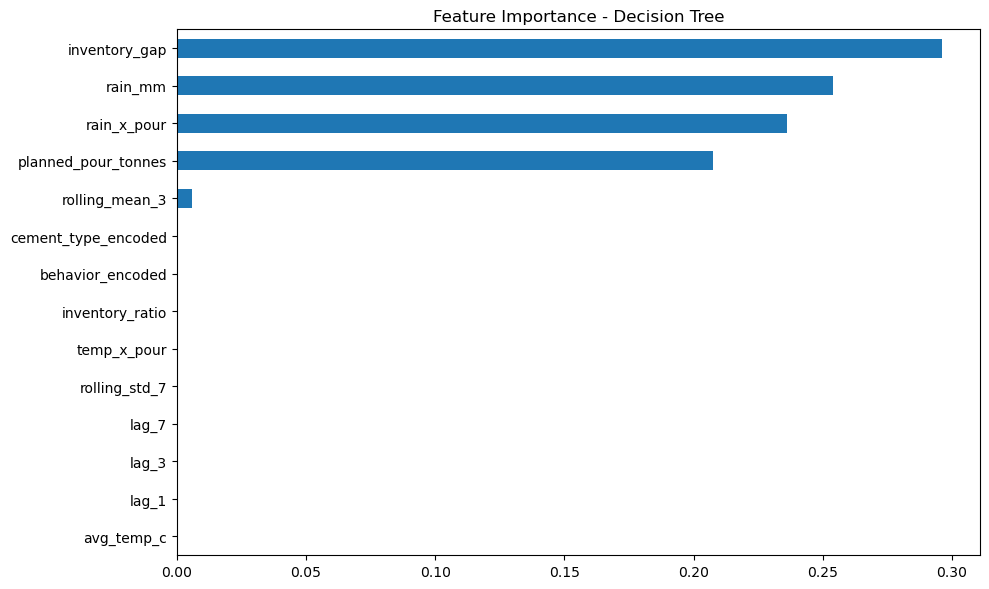

In [47]:
# Feature Importance Visualization
importances = pd.Series(dt_model.feature_importances_, index=features).sort_values()
importances.plot(kind='barh', figsize=(10, 6), title="Feature Importance - Decision Tree")
plt.tight_layout()
plt.show()

In [48]:
dt_model.score(X_train, y_train)

0.9037931626513911

In [49]:
silo_capacity = 1000          # Max storage in tons
initial_inventory = 600       # Starting amount in tons

reorder_threshold = 0.2 * silo_capacity   # 200 tons → when to reorder
target_inventory = 0.8 * silo_capacity    # 800 tons → desired after refill
lead_time_days = 2                         # Delay for deliveries
buffer_rain_threshold = 10                 # mm rain considered "heavy"
buffer_increase = 0.1                      # Add +10% delivery if heavy rain

# Dataframe to store results
df_sim = pd.DataFrame({
    'date': X_test.index,
    'forecasted_consumption': dt_forecast,
    'rain_forecast_mm': X_test['rain_mm'].values
})

Interpretation:

- If stock falls below 200 tons, a reorder is triggered.
- The goal is to refill up to 800 tons.
- Deliveries take 2 days to arrive.
- If rain is forecasted >10 mm, deliveries are increased by 10% as a precaution.

In [50]:
df_sim.isnull().sum()

date                      0
forecasted_consumption    0
rain_forecast_mm          0
dtype: int64

In [51]:
df_sim['sim_inventory'] = np.nan
df_sim['reorder_flag'] = False
df_sim['recommended_delivery_date'] = None
df_sim['recommended_delivery_quantity'] = 0.0
df_sim['buffer_applied'] = False

Additional tracking columns:

- sim_inventory → running inventory
- reorder_flag → did we reorder today?
- recommended_delivery_date → when the delivery is expected
- recommended_delivery_quantity → how much was ordered
- buffer_applied → was the +10% rain buffer applied?

In [52]:
# Looping through each day
inventory = initial_inventory
delivery_queue = {} # deliveries scheduled {date: qty}

for i, row in df_sim.iterrows():
    today = row['date']

    # If a delivery is due today, add it to inventory.
    if today in delivery_queue:
        inventory += delivery_queue[today]
        inventory = min(inventory, silo_capacity) # can't exceed silo capacity
        del delivery_queue[today]

    # Subtract today's consumption
    consumption = row['forecasted_consumption']
    inventory -= consumption

    # Record today's inventory
    df_sim.loc[i, 'sim_inventory'] = inventory

    # Check if we need to reorder
    if inventory < reorder_threshold:
        df_sim.loc[i, 'reorder_flag'] = True
        delivery_date = today + pd.Timedelta(days=lead_time_days)

        # Calculate delivery quantity
        delivery_qty = target_inventory - inventory
        if row['rain_forecast_mm'] > buffer_rain_threshold:
            delivery_qty *= (1 + buffer_increase)
            df_sim.loc[i, 'buffer_applied'] = True

        # Ensure we don't exceed silo capacity
        delivery_qty = min(delivery_qty, silo_capacity - inventory)
        delivery_queue[delivery_date] = delivery_qty

        # Record delivery details
        df_sim.loc[i, 'recommended_delivery_date'] = delivery_date.strftime('%Y-%m-%d')
        df_sim.loc[i, 'recommended_delivery_quantity'] = round(delivery_qty, 2)

## Summary of Logic

Start with 600 tons in silo.

Each day:
- Add any deliveries that arrive.
- Subtract forecasted consumption.
- If stock <200 tons → schedule a delivery for 2 days later.
- Normally deliver enough to reach 800 tons.
- If heavy rain (>10 mm), increase delivery by +10%.
- Ensure delivery never exceeds remaining silo space.
- Keep track of all events in df_sim.

---
So this simulates a supply chain inventory policy with safety buffers:
- Reorder point = 20%
- Target fill level = 80%
- Lead time = 2 days
- Rain buffer = +10% order

In [53]:

stockouts = (df_sim['sim_inventory'] < 0).sum() # Counts the number of days where inventory went below 0 → demand wasn’t met.
service_level = 100 * (1 - stockouts /len(df_sim)) # Service level = % of days with no stockout.
avg_inventory = df_sim['sim_inventory'].mean() # Average inventory over the simulation period.
num_deliveries = (df_sim['reorder_flag']).sum() # Total number of deliveries made

print(f'Service Level: {service_level:.2f}%')
print(f'Stockouts : {stockouts}')
print(f'Average inventory: {avg_inventory:.2f} tonnes')
print(f'Number of deliveries: {num_deliveries}')

output_df = df_sim[['date', 'forecasted_consumption', 'sim_inventory', 'reorder_flag',
                    'recommended_delivery_date', 'recommended_delivery_quantity',
                    'buffer_applied']]

output_df.head(50)

Service Level: 100.00%
Stockouts : 0
Average inventory: 578.04 tonnes
Number of deliveries: 14


,date,forecasted_consumption,sim_inventory,reorder_flag,recommended_delivery_date,recommended_delivery_quantity,buffer_applied
0,2024-05-28,0.000000,600.000000,False,None,0.00,False
1,2024-05-29,37.291280,562.708720,False,None,0.00,False
2,2024-05-30,37.291280,525.417440,False,None,0.00,False
3,2024-05-31,14.744898,510.672542,False,None,0.00,False
4,2024-06-01,21.212632,489.459910,False,None,0.00,False
5,2024-06-02,30.962323,458.497588,False,None,0.00,False
6,2024-06-03,43.498346,414.999242,False,None,0.00,False
7,2024-06-04,30.962323,384.036919,False,None,0.00,False
8,2024-06-05,21.212632,362.824288,False,None,0.00,False
9,2024-06-06,21.212632,341.611656,False,None,0.00,False


```python
output_df = df_sim[['date', 'forecasted_consumption', 'sim_inventory',
                    'reorder_flag', 'recommended_delivery_date',
                    'recommended_delivery_quantity', 'buffer_applied']]
```

This trims the simulation DataFrame to only the most relevant columns:

- date → day in simulation
- forecasted_consumption → demand forecast
- sim_inventory → actual running inventory
- reorder_flag → True/False, did we trigger an order today?
- recommended_delivery_date → when delivery is expected
- recommended_delivery_quantity → how much is coming
- buffer_applied → True if rain-triggered +10% was applied

In [54]:
# -----------------------------
# Feature Engineering
# -----------------------------
def engineer_features(df, site_id):
    site_df = df[df['site_id'] == site_id].copy().sort_values('date')
    site_df.set_index('date', inplace=True)

    # Lags
    site_df['lag_1'] = site_df['consumed_tonnes'].shift(1)
    site_df['lag_3'] = site_df['consumed_tonnes'].shift(3)
    site_df['lag_7'] = site_df['consumed_tonnes'].shift(7)

    # Rolling
    site_df['rolling_mean_3'] = site_df['consumed_tonnes'].rolling(3).mean()
    site_df['rolling_std_7'] = site_df['consumed_tonnes'].rolling(7).std()

    # Calendar
    site_df['day_of_week'] = site_df.index.dayofweek
    site_df['week_of_year'] = site_df.index.isocalendar().week.astype(int)
    site_df['month'] = site_df.index.month

    # Interactions
    site_df['rain_x_pour'] = site_df['rain_mm'] * site_df['planned_pour_tonnes']
    site_df['temp_x_pour'] = site_df['avg_temp_c'] * site_df['planned_pour_tonnes']

    # Inventory
    site_df['inventory_gap'] = site_df['opening_inventory_tonnes'] + site_df['deliveries_tonnes'] - site_df['planned_pour_tonnes']
    site_df['inventory_ratio'] = site_df['closing_inventory_tonnes'] / site_df['silo_capacity']

    # Encodings
    site_df['behavior_encoded'] = site_df['behavior'].astype('category').cat.codes
    site_df['cement_type_encoded'] = site_df['cement_type'].astype('category').cat.codes

    site_df.dropna(inplace=True)
    return site_df

# -----------------------------
# Train Decision Tree and Forecast
# -----------------------------
def train_dt_forecast(site_df):
    features = [
        'planned_pour_tonnes', 'rain_mm', 'avg_temp_c',
        'lag_1', 'lag_3', 'lag_7',
        'rolling_mean_3', 'rolling_std_7',
        'rain_x_pour', 'temp_x_pour',
        'inventory_gap', 'inventory_ratio',
        'behavior_encoded', 'cement_type_encoded'
    ]
    X = site_df[features]
    y = site_df['consumed_tonnes']

    split_index = int(len(site_df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    dt_model = DecisionTreeRegressor(
    max_depth=5, random_state=42)
    dt_model.fit(X_train, y_train)
    dt_forecast = dt_model.predict(X_test)

   

    test_results = site_df.iloc[split_index:].copy()
    test_results['forecasted_consumption'] = dt_forecast

    return dt_model, test_results

# -----------------------------
# Inventory Simulation
# -----------------------------
def simulate_inventory(test_results, site_meta, lead_time=2, buffer_rain_threshold=10, buffer_increase=0.1):
    # ✅ Only simulate on test set horizon
    sim_df = test_results[['consumed_tonnes', 'forecasted_consumption', 'rain_mm']].copy()
    sim_df['sim_inventory'] = np.nan
    sim_df['reorder_flag'] = False
    sim_df['recommended_delivery_date'] = None
    sim_df['recommended_delivery_quantity'] = 0.0
    sim_df['buffer_applied'] = False

    inventory = site_meta['initial_inventory']
    capacity = site_meta['silo_capacity']
    reorder_threshold = site_meta['reorder_threshold']
    target_inventory = site_meta['target_inventory']

    delivery_queue = {}

    for today, row in sim_df.iterrows():
        # Apply deliveries arriving today
        if today in delivery_queue:
            inventory += delivery_queue[today]
            inventory = min(inventory, capacity)
            del delivery_queue[today]

        # Consume forecasted demand
        inventory -= row['forecasted_consumption']
        sim_df.loc[today, 'sim_inventory'] = inventory

        # Check reorder
        if inventory < reorder_threshold:
            sim_df.loc[today, 'reorder_flag'] = True
            delivery_date = today + pd.Timedelta(days=lead_time)

            delivery_qty = target_inventory - inventory
            if row['rain_mm'] > buffer_rain_threshold:
                delivery_qty *= (1 + buffer_increase)
                sim_df.loc[today, 'buffer_applied'] = True

            delivery_qty = min(delivery_qty, capacity - inventory)
            delivery_queue[delivery_date] = delivery_qty

            sim_df.loc[today, 'recommended_delivery_date'] = delivery_date.strftime('%Y-%m-%d')
            sim_df.loc[today, 'recommended_delivery_quantity'] = round(delivery_qty, 2)

    return sim_df

# -----------------------------
# Full Multi-Site Pipeline
# -----------------------------
def run_pipeline(df, site_metadata):
    all_results = []

    for site_id in df['site_id'].unique():
        print(f"Processing {site_id}...")
        site_df = engineer_features(df, site_id)

        if len(site_df) < 50:
            print(f"Skipping {site_id}, not enough data")
            continue

        dt_model, test_results = train_dt_forecast(site_df)
        sim_results = simulate_inventory(test_results, site_metadata[site_id])
        sim_results['site_id'] = site_id

        all_results.append(sim_results.reset_index())

    return pd.concat(all_results, ignore_index=True)

In [55]:
df['site_id'].unique()

array(['SITE_001', 'SITE_002', 'SITE_003', 'SITE_004', 'SITE_005',
       'SITE_006', 'SITE_007', 'SITE_008', 'SITE_009', 'SITE_010',
       'SITE_011', 'SITE_012', 'SITE_013', 'SITE_014', 'SITE_015',
       'SITE_016', 'SITE_017', 'SITE_018', 'SITE_019', 'SITE_020',
       'SITE_021', 'SITE_022', 'SITE_023', 'SITE_024', 'SITE_025',
       'SITE_026', 'SITE_027', 'SITE_028', 'SITE_029', 'SITE_030'],
      dtype=object)

script used to generate site meatadata to test pipeline

```python

def generate_site_metadata():
    site_metadata = {}
    site_configs = [
        (1200, 674, 240, 960), (2500, 1421, 500, 2000), (1000, 592, 200, 800),
        (1500, 899, 300, 1200), (1200, 640, 240, 960), (1800, 1070, 360, 1440),
        (2000, 1198, 400, 1600), (1000, 612, 200, 800), (1500, 891, 300, 1200),
        (2200, 1387, 440, 1760), (1200, 701, 240, 960), (1000, 603, 200, 800),
        (1800, 1084, 360, 1440), (1500, 902, 300, 1200), (2000, 1235, 400, 1600),
        (1200, 689, 240, 960), (2500, 1453, 500, 2000), (1500, 874, 300, 1200),
        (1800, 1102, 360, 1440), (1000, 583, 200, 800), (2200, 1364, 440, 1760),
        (1200, 651, 240, 960), (1500, 900, 300, 1200), (1800, 1111, 360, 1440),
        (2000, 1180, 400, 1600), (1000, 594, 200, 800), (1200, 662, 240, 960),
        (1500, 917, 300, 1200), (1800, 1095, 360, 1440), (2000, 1210, 400, 1600)
    ]

    for i, (capacity, inventory, threshold, target) in enumerate(site_configs, start=1):
        site_id = f"SITE_{i:03d}"
        site_metadata[site_id] = {
            "silo_capacity": capacity,
            "initial_inventory": inventory,
            "reorder_threshold": threshold,
            "target_inventory": target
        }

    return site_metadata

if __name__ == "__main__":
    metadata = generate_site_metadata()
    for site, data in metadata.items():
        print(f"{site}: {data}")
```

In [56]:
site_metadata = {
    "SITE_001": {"silo_capacity": 1200, "initial_inventory": 674, "reorder_threshold": 240, "target_inventory": 960},
    "SITE_002": {"silo_capacity": 2500, "initial_inventory": 1421, "reorder_threshold": 500, "target_inventory": 2000},
    "SITE_003": {"silo_capacity": 1000, "initial_inventory": 592, "reorder_threshold": 200, "target_inventory": 800},
    "SITE_004": {"silo_capacity": 1500, "initial_inventory": 899, "reorder_threshold": 300, "target_inventory": 1200},
    "SITE_005": {"silo_capacity": 1200, "initial_inventory": 640, "reorder_threshold": 240, "target_inventory": 960},
    "SITE_006": {"silo_capacity": 1800, "initial_inventory": 1070, "reorder_threshold": 360, "target_inventory": 1440},
    "SITE_007": {"silo_capacity": 2000, "initial_inventory": 1198, "reorder_threshold": 400, "target_inventory": 1600},
    "SITE_008": {"silo_capacity": 1000, "initial_inventory": 612, "reorder_threshold": 200, "target_inventory": 800},
    "SITE_009": {"silo_capacity": 1500, "initial_inventory": 891, "reorder_threshold": 300, "target_inventory": 1200},
    "SITE_010": {"silo_capacity": 2200, "initial_inventory": 1387, "reorder_threshold": 440, "target_inventory": 1760},
    "SITE_011": {"silo_capacity": 1200, "initial_inventory": 701, "reorder_threshold": 240, "target_inventory": 960},
    "SITE_012": {"silo_capacity": 1000, "initial_inventory": 603, "reorder_threshold": 200, "target_inventory": 800},
    "SITE_013": {"silo_capacity": 1800, "initial_inventory": 1084, "reorder_threshold": 360, "target_inventory": 1440},
    "SITE_014": {"silo_capacity": 1500, "initial_inventory": 902, "reorder_threshold": 300, "target_inventory": 1200},
    "SITE_015": {"silo_capacity": 2000, "initial_inventory": 1235, "reorder_threshold": 400, "target_inventory": 1600},
    "SITE_016": {"silo_capacity": 1200, "initial_inventory": 689, "reorder_threshold": 240, "target_inventory": 960},
    "SITE_017": {"silo_capacity": 2500, "initial_inventory": 1453, "reorder_threshold": 500, "target_inventory": 2000},
    "SITE_018": {"silo_capacity": 1500, "initial_inventory": 874, "reorder_threshold": 300, "target_inventory": 1200},
    "SITE_019": {"silo_capacity": 1800, "initial_inventory": 1102, "reorder_threshold": 360, "target_inventory": 1440},
    "SITE_020": {"silo_capacity": 1000, "initial_inventory": 583, "reorder_threshold": 200, "target_inventory": 800},
    "SITE_021": {"silo_capacity": 2200, "initial_inventory": 1364, "reorder_threshold": 440, "target_inventory": 1760},
    "SITE_022": {"silo_capacity": 1200, "initial_inventory": 651, "reorder_threshold": 240, "target_inventory": 960},
    "SITE_023": {"silo_capacity": 1500, "initial_inventory": 900, "reorder_threshold": 300, "target_inventory": 1200},
    "SITE_024": {"silo_capacity": 1800, "initial_inventory": 1111, "reorder_threshold": 360, "target_inventory": 1440},
    "SITE_025": {"silo_capacity": 2000, "initial_inventory": 1180, "reorder_threshold": 400, "target_inventory": 1600},
    "SITE_026": {"silo_capacity": 1000, "initial_inventory": 594, "reorder_threshold": 200, "target_inventory": 800},
    "SITE_027": {"silo_capacity": 1200, "initial_inventory": 662, "reorder_threshold": 240, "target_inventory": 960},
    "SITE_028": {"silo_capacity": 1500, "initial_inventory": 917, "reorder_threshold": 300, "target_inventory": 1200},
    "SITE_029": {"silo_capacity": 1800, "initial_inventory": 1095, "reorder_threshold": 360, "target_inventory": 1440},
    "SITE_030": {"silo_capacity": 2000, "initial_inventory": 1210, "reorder_threshold": 400, "target_inventory": 1600},
}

In [57]:
results_df = run_pipeline(df, site_metadata)

Processing SITE_001...
Processing SITE_002...
Processing SITE_003...
Processing SITE_004...
Processing SITE_005...
Processing SITE_006...
Processing SITE_007...
Processing SITE_008...
Processing SITE_009...
Processing SITE_010...
Processing SITE_011...
Processing SITE_012...
Processing SITE_013...
Processing SITE_014...
Processing SITE_015...
Processing SITE_016...
Processing SITE_017...
Processing SITE_018...
Processing SITE_019...
Processing SITE_020...
Processing SITE_021...
Processing SITE_022...
Processing SITE_023...
Processing SITE_024...
Processing SITE_025...
Processing SITE_026...
Processing SITE_027...
Processing SITE_028...
Processing SITE_029...
Processing SITE_030...


In [58]:
results_df.to_parquet('cement_forecast_results.parquet', index=False)

In [59]:
# Calculate MAPE for each site in the pipeline
from sklearn.metrics import mean_absolute_percentage_error

performance_summary = []

for site_id in df['site_id'].unique():
    print(f"Evaluating model for {site_id}...")
    
    # Prepare site data
    site_df = engineer_features(df, site_id)
    
    if len(site_df) < 50:
        print(f"Skipping {site_id}, not enough data")
        continue
        
    # Get features and target
    features = [
        'planned_pour_tonnes', 'rain_mm', 'avg_temp_c',
        'lag_1', 'lag_3', 'lag_7',
        'rolling_mean_3', 'rolling_std_7',
        'rain_x_pour', 'temp_x_pour',
        'inventory_gap', 'inventory_ratio',
        'behavior_encoded', 'cement_type_encoded'
    ]
    X = site_df[features]
    y = site_df['consumed_tonnes']
    
    # Time-based split
    split_index = int(len(site_df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    # Train and predict
    dt_model = DecisionTreeRegressor(
    max_depth=5, random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    
    # Calculate metrics - handling zero values properly
    mask = y_test != 0  # Avoid division by zero
    if mask.sum() > 0:  # Ensure we have non-zero values to evaluate
        mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100
    else:
        mape = 0  # If all test values are zero, prediction is perfect
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store results
    performance_summary.append({
        'site_id': site_id,
        'test_samples': len(y_test),
        'non_zero_samples': mask.sum(),
        'mape': mape,
        'rmse': rmse,
        'avg_consumption': y_test.mean()
    })

# Create performance dataframe
performance_df = pd.DataFrame(performance_summary)

# Display overall performance
print("\n" + "="*60)
print("OVERALL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Average MAPE across all sites: {performance_df['mape'].mean():.2f}%")
print(f"Median MAPE across all sites: {performance_df['mape'].median():.2f}%")
print(f"Sites achieving MAPE ≤ 15%: {(performance_df['mape'] <= 15).sum()}/{len(performance_df)}")
print(f"Sites with MAPE > 15%: {(performance_df['mape'] > 15).sum()}/{len(performance_df)}")

# Display detailed performance table
print("\nDetailed Performance by Site:")
print(performance_df.sort_values('mape').to_string(index=False))

# Identify sites that need attention
problem_sites = performance_df[performance_df['mape'] > 15]
if not problem_sites.empty:
    print("\n" + "!"*60)
    print("SITES NEEDING ATTENTION (MAPE > 15%):")
    print("!"*60)
    print(problem_sites[['site_id', 'mape', 'avg_consumption', 'test_samples']].to_string(index=False))
else:
    print("\n🎉 ALL SITES ACHIEVED TARGET MAPE OF 15% OR BETTER! 🎉")

Evaluating model for SITE_001...
Evaluating model for SITE_002...
Evaluating model for SITE_003...
Evaluating model for SITE_004...
Evaluating model for SITE_005...
Evaluating model for SITE_006...
Evaluating model for SITE_007...
Evaluating model for SITE_008...
Evaluating model for SITE_009...
Evaluating model for SITE_010...
Evaluating model for SITE_011...
Evaluating model for SITE_012...
Evaluating model for SITE_013...
Evaluating model for SITE_014...
Evaluating model for SITE_015...
Evaluating model for SITE_016...
Evaluating model for SITE_017...
Evaluating model for SITE_018...
Evaluating model for SITE_019...
Evaluating model for SITE_020...
Evaluating model for SITE_021...
Evaluating model for SITE_022...
Evaluating model for SITE_023...
Evaluating model for SITE_024...
Evaluating model for SITE_025...
Evaluating model for SITE_026...
Evaluating model for SITE_027...
Evaluating model for SITE_028...
Evaluating model for SITE_029...
Evaluating model for SITE_030...

OVERALL M

In [60]:
performance_df = pd.DataFrame(performance_summary)

In [61]:
performance_df.head(30)

,site_id,test_samples,non_zero_samples,mape,rmse,avg_consumption
0,SITE_001,218,186,16.857942,5.084184,28.425183
1,SITE_002,218,211,3.004929,0.466159,11.694541
2,SITE_003,218,189,13.923787,4.953418,30.014633
3,SITE_004,218,202,3.845381,0.522297,10.411789
4,SITE_005,218,179,16.190419,5.898997,29.568257
5,SITE_006,218,156,14.933529,5.160147,24.961055
6,SITE_007,218,190,14.177955,4.893275,29.630596
7,SITE_008,218,197,19.906198,6.200324,28.749220
8,SITE_009,218,213,4.145362,0.565046,11.180734
9,SITE_010,218,204,17.652321,6.726625,29.783670


In [64]:
# Define the parameter grid for manual grid search
import itertools  # <- added import to fix NameError
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10, 20]
}

# Generate all possible parameter combinations
all_param_combinations = list(itertools.product(
    param_grid['max_depth'],
    param_grid['min_samples_leaf']
))

performance_summary = []
best_params_summary = []

for site_id in df['site_id'].unique():
    print(f"Evaluating model for {site_id}...")

    # Prepare site data
    site_df = engineer_features(df, site_id)

    if len(site_df) < 50:
        print(f"Skipping {site_id}, not enough data")
        continue

    # Ensure encoded columns exist
    for col in ['behavior_encoded', 'cement_type_encoded']:
        if col not in site_df.columns:
            site_df[col] = 0 # or use your real encoding logic

    features = [
        'planned_pour_tonnes', 'rain_mm', 'avg_temp_c',
        'lag_1', 'lag_3', 'lag_7',
        'rolling_mean_3', 'rolling_std_7',
        'rain_x_pour', 'temp_x_pour',
        'inventory_gap', 'inventory_ratio',
        'behavior_encoded', 'cement_type_encoded'
    ]
    X = site_df[features]
    y = site_df['consumed_tonnes']

    # Time-based split (chronological)
    split_index = int(len(site_df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Loop to find the best parameters
    best_mape = float('inf')
    best_model = None
    best_params = {}

    for depth, leaf_size in all_param_combinations:
        model = DecisionTreeRegressor(
            max_depth=depth,
            min_samples_leaf=leaf_size,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mask = y_test != 0        # Avoid division by zero in MAPE
        if mask.sum() > 0:
            mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100
        else:
            mape = 0

        if mape < best_mape:
            best_mape = mape
            best_model = model
            best_params = {'max_depth': depth, 'min_samples_leaf': leaf_size}

    # Final predictions using best model/params
    y_pred_best = best_model.predict(X_test)
    rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

    # Store results (note: use best_mape and rmse_best)
    performance_summary.append({
        'site_id': site_id,
        'test_samples': len(y_test),
        'non_zero_samples': (y_test != 0).sum(),
        'mape': best_mape,
        'rmse': rmse_best,
        'avg_consumption': y_test.mean()
    })
    best_params_summary.append({
        'site_id': site_id,
        **best_params
    })

# Create performance dataframe
performance_df1 = pd.DataFrame(performance_summary)

# Display overall performance
print("\n" + "="*60)
print("OVERALL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Average MAPE across all sites: {performance_df1['mape'].mean():.2f}%")
print(f"Median MAPE across all sites: {performance_df1['mape'].median():.2f}%")
print(f"Sites achieving MAPE ≤ 15%: {(performance_df1['mape'] <= 15).sum()}/{len(performance_df1)}")
print(f"Sites with MAPE > 15%: {(performance_df1['mape'] > 15).sum()}/{len(performance_df1)}")

# Display detailed performance table
print("\nDetailed Performance by Site:")
print(performance_df1.sort_values('mape').to_string(index=False))

# Identify sites that need attention
problem_sites = performance_df1[performance_df1['mape'] > 15]
if not problem_sites.empty:
    print("\n" + "!"*60)
    print("SITES NEEDING ATTENTION (MAPE > 15%):")
    print("!"*60)
    print(problem_sites[['site_id', 'mape', 'avg_consumption', 'test_samples']].to_string(index=False))
else:
    print("\n🎉 ALL SITES ACHIEVED TARGET MAPE OF 15% OR BETTER! 🎉")


Evaluating model for SITE_001...
Evaluating model for SITE_002...
Evaluating model for SITE_003...
Evaluating model for SITE_004...
Evaluating model for SITE_005...
Evaluating model for SITE_006...
Evaluating model for SITE_007...
Evaluating model for SITE_008...
Evaluating model for SITE_009...
Evaluating model for SITE_010...
Evaluating model for SITE_011...
Evaluating model for SITE_012...
Evaluating model for SITE_013...
Evaluating model for SITE_014...
Evaluating model for SITE_015...
Evaluating model for SITE_016...
Evaluating model for SITE_017...
Evaluating model for SITE_018...
Evaluating model for SITE_019...
Evaluating model for SITE_020...
Evaluating model for SITE_021...
Evaluating model for SITE_022...
Evaluating model for SITE_023...
Evaluating model for SITE_024...
Evaluating model for SITE_025...
Evaluating model for SITE_026...
Evaluating model for SITE_027...
Evaluating model for SITE_028...
Evaluating model for SITE_029...
Evaluating model for SITE_030...

OVERALL M

In [65]:
performance_df1 = pd.DataFrame(performance_summary)

In [66]:
performance_df1

,site_id,test_samples,non_zero_samples,mape,rmse,avg_consumption
0,SITE_001,218,186,5.231824,2.138033,28.425183
1,SITE_002,218,211,1.030246,0.371255,11.694541
2,SITE_003,218,189,5.758239,2.629193,30.014633
3,SITE_004,218,202,1.572369,0.416028,10.411789
4,SITE_005,218,179,6.735757,3.271895,29.568257
5,SITE_006,218,156,5.848868,3.213192,24.961055
6,SITE_007,218,190,5.225546,1.815880,29.630596
7,SITE_008,218,197,10.414080,3.828557,28.749220
8,SITE_009,218,213,1.129543,0.343862,11.180734
9,SITE_010,218,204,6.871972,3.844522,29.783670


In [67]:
best_params_df1 = pd.DataFrame(best_params_summary)

In [68]:
best_params_df1

,site_id,max_depth,min_samples_leaf
0,SITE_001,20,2
1,SITE_002,10,2
2,SITE_003,15,2
3,SITE_004,10,2
4,SITE_005,20,2
5,SITE_006,20,2
6,SITE_007,20,2
7,SITE_008,10,2
8,SITE_009,10,2
9,SITE_010,10,2


In [69]:
# Only consider the delivery if there's enough space in the silo
if inventory + delivery_qty <= silo_capacity:
    delivery_queue[delivery_date] = delivery_qty

    df_sim.loc[i, 'recommended_delivery_date'] = delivery_date.strftime('%Y-%m-%d')
    df_sim.loc[i, 'recommended_delivery_quantity'] = round(delivery_qty, 2)
else:
    # If there's no space in the silo, don't recommend any new deliveries
    df_sim.loc[i, 'recommended_delivery_date'] = 'N/A'
    df_sim.loc[i, 'recommended_delivery_quantity'] = 0

In [ ]:
import pandas as pd
import dash
from dash import dcc, html, dash_table, callback, Input, Output
import plotly.graph_objects as go
import dash_bootstrap_components as dbc
import warnings

# Ignore any warnings during runtime
warnings.filterwarnings("ignore")

# Load the necessary data
# Load the historical KPI summary CSV data
kpi_summary = pd.read_csv("historical_kpi_summary.csv")
# Load the cement forecast results Parquet data
results_df = pd.read_parquet("cement_forecast_results.parquet")

# Ensure correct data types for date and numerical columns
# Convert 'date' column to datetime type for proper handling in the dashboard
results_df["date"] = pd.to_datetime(results_df["date"])
# Ensure percentage columns in kpi_summary are treated as floats
kpi_summary["stockout_pct"] = kpi_summary["stockout_pct"].astype(float)
kpi_summary["overcapacity_pct"] = kpi_summary["overcapacity_pct"].astype(float)

# Initialize Dash app with Bootstrap styling
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.title = "MIG Cement Operational Planner"  # Sets the browser tab title

# Custom CSS for layout (styling within HTML)
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>{%title%}</title>
        {%favicon%}
        {%css%}
        <style>
            .fixed-height-graph {
                height: 450px;
            }
            .fixed-height-card {
                height: 200px;
            }
            .scrollable-container {
                max-height: 400px;
                overflow-y: auto;
                overflow-x: hidden;
            }
            body, html {
                height: 100%;
                margin: 0;
            }
            .main-container {
                height: 100vh;
                display: flex;
                flex-direction: column;
            }
        </style>
    </head>
    <body>
        <div class="main-container">
            {%app_entry%}
        </div>
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''

# =======================
# App Layout
# =======================
# The layout consists of several sections: 
# - A header
# - Site selection dropdown
# - KPI cards
# - Inventory time series graph
# - Reorder recommendations table
app.layout = dbc.Container([

    # Header Section
    html.H1("MIG Cement Operational Planner", 
            className="text-center my-4", style={'color': '#2c3e50'}),

    # Site Selection Dropdown
    # Allows the user to select a site from the available list in the forecast data
    dbc.Row([
        dbc.Col([
            html.Label("Select Site:", className="font-weight-bold"),
            dcc.Dropdown(
                id="site-dropdown",
                options=[{"label": s, "value": s} for s in sorted(results_df["site_id"].unique())],
                value=sorted(results_df["site_id"].unique())[0],
                clearable=False  # Disables the option to clear the selection
            )
        ], width=6)
    ], className="mb-4"),

    # KPI Cards Section
    # These cards display key performance indicators related to the selected site
    dbc.Row(id="kpi-cards", className="mb-4"),

    # Inventory Time Series Graph Section
    # Displays the simulated inventory and forecasted consumption over time
    dbc.Row([
        dbc.Col(
            html.Div(
                dcc.Graph(id="inventory-timeseries"),
                className="fixed-height-graph"
            ), 
            width=12
        )
    ], className="mb-4"),

    # Reorder Recommendations Table Section
    # Displays a table of upcoming reorder recommendations
    dbc.Row([
        dbc.Col([
            html.H4("Upcoming Reorder Recommendations"),
            html.Div(
                dash_table.DataTable(
                    id="reorder-table",
                    columns=[
                        {"name": "Date", "id": "date"},
                        {"name": "Inventory (t)", "id": "sim_inventory"},
                        {"name": "Delivery Date", "id": "recommended_delivery_date"},
                        {"name": "Quantity (t)", "id": "recommended_delivery_quantity"},
                        {"name": "Rain Buffer", "id": "buffer_applied"}
                    ],
                    style_table={"overflowX": "auto"},
                    style_cell={"textAlign": "center", "padding": "10px"},
                    style_header={"backgroundColor": "#f8f9fa", "fontWeight": "bold"},
                    page_size=5,  # Displays 5 rows per page
                    style_data={'whiteSpace': 'normal', 'height': 'auto'}
                ),
                className="scrollable-container"
            )
        ], width=12)
    ])

], fluid=True, style={'height': '100%', 'display': 'flex', 'flexDirection': 'column'})

# =======================
# Callbacks
# =======================
# The callback updates the content of the dashboard dynamically based on the selected site
@app.callback(
    [Output("inventory-timeseries", "figure"),
     Output("reorder-table", "data"),
     Output("kpi-cards", "children")],
    [Input("site-dropdown", "value")]
)
def update_planner_dashboard(site_id):
    # Filter data for the selected site
    site_df = results_df[results_df["site_id"] == site_id].copy()
    
    # KPI Cards
    # Calculate total forecast, reorders, average inventory, and silo capacity for the selected site
    total_forecast = site_df["forecasted_consumption"].sum()
    total_reorders = site_df["reorder_flag"].sum()
    avg_inventory = site_df["sim_inventory"].mean()
    silo_capacity = kpi_summary[kpi_summary['site_id'] == site_id]['silo_capacity'].values[0]
    
    # Create the KPI cards dynamically based on the calculated values
    kpi_cards = [
        dbc.Col(dbc.Card([
            dbc.CardHeader("Total Forecasted Consumption", className="bg-primary text-white"),
            dbc.CardBody([html.H4(f"{total_forecast:,.0f} t", className="card-title")])
        ], className="fixed-height-card"), width=3),
        dbc.Col(dbc.Card([
            dbc.CardHeader("Planned Reorders", className="bg-info text-white"),
            dbc.CardBody([html.H4(f"{total_reorders}", className="card-title")])
        ], className="fixed-height-card"), width=3),
        dbc.Col(dbc.Card([
            dbc.CardHeader("Average Inventory", className="bg-success text-white"),
            dbc.CardBody([html.H4(f"{avg_inventory:,.0f} t", className="card-title")])
        ], className="fixed-height-card"), width=3),
        dbc.Col(dbc.Card([
            dbc.CardHeader("Utilization Rate", className="bg-warning text-dark"),
            dbc.CardBody([html.H4(f"{(avg_inventory/silo_capacity)*100:.1f}%", className="card-title")])
        ], className="fixed-height-card"), width=3)
    ]
    
    # Time Series Plot
    # This plot shows the inventory and forecasted consumption over time
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=site_df["date"], y=site_df["sim_inventory"],
        mode="lines", name="Simulated Inventory",
        line=dict(color="blue"), fill='tozeroy'
    ))
    fig.add_trace(go.Bar(
        x=site_df["date"], y=site_df["forecasted_consumption"],
        name="Forecasted Consumption", yaxis="y2",
        opacity=0.6, marker_color='orange'
    ))
    
    # Highlight reorder trigger points with red markers
    reorder_points = site_df[site_df["reorder_flag"] == True]
    fig.add_trace(go.Scatter(
        x=reorder_points["date"], y=reorder_points["sim_inventory"],
        mode="markers", name="Reorder Trigger",
        marker=dict(color="red", size=10, symbol="x")
    ))
    
    # Update layout for the time series plot (titles, axes, legend, etc.)
    fig.update_layout(
        title=f"Inventory & Demand Forecast - {site_id}",
        xaxis=dict(title="Date"),
        yaxis=dict(title="Inventory (t)"),
        yaxis2=dict(title="Forecasted Consumption (t)", overlaying="y", side="right"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=450,
        margin=dict(l=20, r=20, t=60, b=20),
        hovermode="x unified"
    )
    
    # Reorder Table Data
    # Filter data for reorder recommendations and format the date column
    reorder_data = site_df[site_df["reorder_flag"] == True][[
        "date", "sim_inventory", "recommended_delivery_date",
        "recommended_delivery_quantity", "buffer_applied"
    ]].copy()
    reorder_data['date'] = reorder_data['date'].dt.strftime('%Y-%m-%d')
    
    # Return updated figures, table data, and KPI cards
    return fig, reorder_data.to_dict("records"), kpi_cards

# =======================
# Run the app
# =======================
# Start the Dash app server
if __name__ == "__main__":
    app.run(debug=True, port=8050)
